In [88]:
#Load the libraries
import pandas as pd
import numpy as np

#visualization
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

#Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

#Model
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

import joblib

In [31]:
#read the files
train = pd.read_csv('train_loan_data.csv')
test = pd.read_csv('test_loan_data.csv')
result = pd.read_csv('test_results.csv')

In [32]:
train.shape, test.shape, result.shape

((80000, 28), (20000, 27), (20000, 1))

In [33]:
train.info(), test.info(), result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   addr_state            80000 non-null  object 
 1   annual_inc            80000 non-null  float64
 2   earliest_cr_line      80000 non-null  object 
 3   emp_length            75412 non-null  object 
 4   emp_title             74982 non-null  object 
 5   fico_range_high       80000 non-null  float64
 6   fico_range_low        80000 non-null  float64
 7   grade                 80000 non-null  object 
 8   home_ownership        80000 non-null  object 
 9   application_type      80000 non-null  object 
 10  initial_list_status   80000 non-null  object 
 11  int_rate              80000 non-null  float64
 12  loan_amnt             80000 non-null  float64
 13  num_actv_bc_tl        76052 non-null  float64
 14  mort_acc              77229 non-null  float64
 15  tot_cur_bal        

(None, None, None)

In [34]:
display(train.head(2), test.head(2),result.head(2))

,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,loan_status
0,CO,85000.0,Jul-1997,10+ years,Deputy,744.0,740.0,E,MORTGAGE,Individual,...,0.0,debt_consolidation,5338.0,93.6,E1,60 months,Debt consolidation,8.0,Source Verified,Charged Off
1,CA,40000.0,Apr-1987,10+ years,Department of Veterans Affairs,724.0,720.0,B,RENT,Individual,...,0.0,debt_consolidation,19944.0,60.3,B1,36 months,Credit Loan,12.0,Verified,Fully Paid


,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status
0,MO,50000.0,May-2012,1 year,Tower technician,719.0,715.0,C,OWN,Individual,...,0.0,0.0,debt_consolidation,2568.0,9.8,C4,36 months,Debt consolidation,11.0,Source Verified
1,HI,92000.0,Dec-2001,10+ years,Supervisor,684.0,680.0,B,RENT,Individual,...,0.0,0.0,debt_consolidation,30394.0,75.4,B2,36 months,Debt consolidation,35.0,Source Verified


,loan_status
0,Fully Paid
1,Fully Paid


## EDA and Preprocessing

In [35]:
train.duplicated().sum(), test.duplicated().sum()

(0, 0)

In [36]:
data = pd.concat([train,test])
data.shape

(100000, 28)

In [37]:
data.columns

Index(['addr_state', 'annual_inc', 'earliest_cr_line', 'emp_length',
       'emp_title', 'fico_range_high', 'fico_range_low', 'grade',
       'home_ownership', 'application_type', 'initial_list_status', 'int_rate',
       'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'purpose', 'revol_bal', 'revol_util',
       'sub_grade', 'term', 'title', 'total_acc', 'verification_status',
       'loan_status'],
      dtype='object')

In [38]:
data.head(2)

,addr_state,annual_inc,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,home_ownership,application_type,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,loan_status
0,CO,85000.0,Jul-1997,10+ years,Deputy,744.0,740.0,E,MORTGAGE,Individual,...,0.0,debt_consolidation,5338.0,93.6,E1,60 months,Debt consolidation,8.0,Source Verified,Charged Off
1,CA,40000.0,Apr-1987,10+ years,Department of Veterans Affairs,724.0,720.0,B,RENT,Individual,...,0.0,debt_consolidation,19944.0,60.3,B1,36 months,Credit Loan,12.0,Verified,Fully Paid


In [39]:
cat_cols = data.drop(columns='loan_status').select_dtypes(include = object).columns
num_cols = data.select_dtypes(include=np.number).columns
print(cat_cols,num_cols)

Index(['addr_state', 'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'application_type', 'initial_list_status', 'purpose',
       'sub_grade', 'term', 'title', 'verification_status'],
      dtype='object') Index(['annual_inc', 'fico_range_high', 'fico_range_low', 'int_rate',
       'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'total_acc'],
      dtype='object')


<Axes: ylabel='loan_status'>

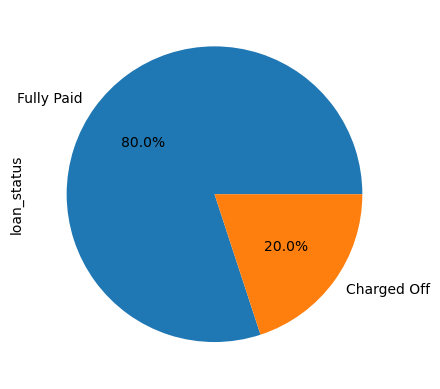

In [40]:
data['loan_status'].value_counts().plot.pie(autopct = '%1.1f%%')

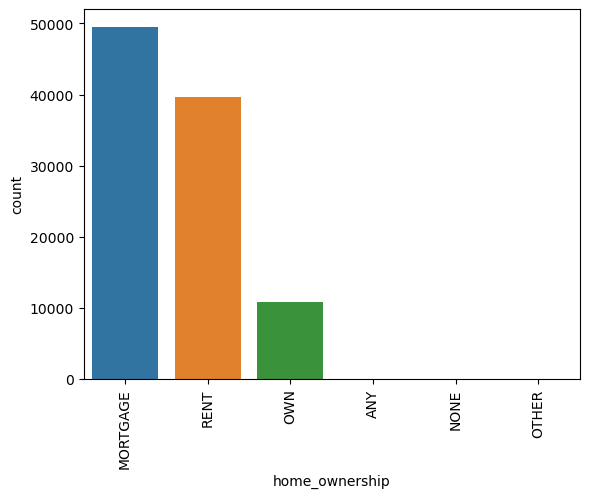

In [41]:
plot = sns.countplot(x='home_ownership',data=data)
plt.setp(plot.get_xticklabels(),rotation=90)
plt.show()

loan_status,Charged Off,Fully Paid
home_ownership,,
ANY,2,17
MORTGAGE,6783,32845
NONE,0,4
OTHER,4,3
OWN,1779,6875
RENT,7402,24286


array([<Axes: ylabel='Charged Off'>, <Axes: ylabel='Fully Paid'>],
      dtype=object)

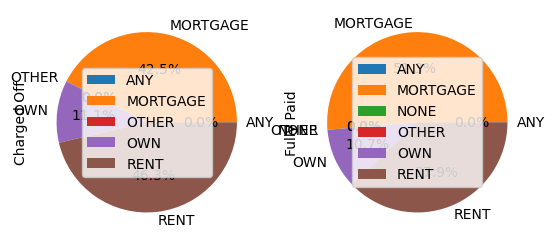

In [42]:
display(pd.crosstab(data['home_ownership'],data['loan_status']))
pd.crosstab(data['home_ownership'],data['loan_status']).plot.pie(autopct='%1.1f%%',subplots=True)

In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 0 to 19999
Data columns (total 28 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   addr_state            100000 non-null  object 
 1   annual_inc            100000 non-null  float64
 2   earliest_cr_line      100000 non-null  object 
 3   emp_length            94154 non-null   object 
 4   emp_title             93604 non-null   object 
 5   fico_range_high       100000 non-null  float64
 6   fico_range_low        100000 non-null  float64
 7   grade                 100000 non-null  object 
 8   home_ownership        100000 non-null  object 
 9   application_type      100000 non-null  object 
 10  initial_list_status   100000 non-null  object 
 11  int_rate              100000 non-null  float64
 12  loan_amnt             100000 non-null  float64
 13  num_actv_bc_tl        95041 non-null   float64
 14  mort_acc              96525 non-null   float64
 15  t

In [44]:
data.isna().sum()

addr_state                  0
annual_inc                  0
earliest_cr_line            0
emp_length               5846
emp_title                6396
fico_range_high             0
fico_range_low              0
grade                       0
home_ownership              0
application_type            0
initial_list_status         0
int_rate                    0
loan_amnt                   0
num_actv_bc_tl           4959
mort_acc                 3475
tot_cur_bal              4959
open_acc                    0
pub_rec                     0
pub_rec_bankruptcies       42
purpose                     0
revol_bal                   0
revol_util                 66
sub_grade                   0
term                        0
title                    1217
total_acc                   0
verification_status         0
loan_status             20000
dtype: int64

In [46]:
#Handling missing values in object datatype:

data['emp_length'].fillna(data['emp_length'].mode()[0],inplace=True)
data['emp_title'].fillna(data['emp_title'].mode()[0],inplace=True)
data['title'].fillna(data['title'].mode()[0],inplace=True)

In [ ]:
#Handling missing values in 

In [47]:
data.nunique()

addr_state                 51
annual_inc               9060
earliest_cr_line          644
emp_length                 11
emp_title               44316
fico_range_high            38
fico_range_low             38
grade                       7
home_ownership              6
application_type            2
initial_list_status         2
int_rate                  561
loan_amnt                1397
num_actv_bc_tl             28
mort_acc                   28
tot_cur_bal             79062
open_acc                   56
pub_rec                    16
pub_rec_bankruptcies        9
purpose                    14
revol_bal               36117
revol_util               1091
sub_grade                  35
term                        2
title                    6506
total_acc                 110
verification_status         3
loan_status                 2
dtype: int64

In [48]:
#List comprehension
[print(i,data[i].nunique(),data[i].unique())
for i in data.columns if data[i].nunique()<20]

emp_length 11 ['10+ years' '3 years' '< 1 year' '1 year' '8 years' '7 years' '4 years'
 '2 years' '5 years' '6 years' '9 years']
grade 7 ['E' 'B' 'F' 'D' 'C' 'A' 'G']
home_ownership 6 ['MORTGAGE' 'RENT' 'OWN' 'ANY' 'NONE' 'OTHER']
application_type 2 ['Individual' 'Joint App']
initial_list_status 2 ['w' 'f']
pub_rec 16 [ 0.  1.  2.  3.  6.  4.  5.  8. 10.  7. 13. 11. 24. 15.  9. 12.]
pub_rec_bankruptcies 9 [ 0.  1.  2.  3.  5. nan  4.  7.  6.  8.]
purpose 14 ['debt_consolidation' 'home_improvement' 'credit_card' 'other'
 'small_business' 'medical' 'major_purchase' 'car' 'vacation' 'house'
 'moving' 'wedding' 'renewable_energy' 'educational']
term 2 [' 60 months' ' 36 months']
verification_status 3 ['Source Verified' 'Verified' 'Not Verified']
loan_status 2 ['Charged Off' 'Fully Paid' nan]


[None, None, None, None, None, None, None, None, None, None, None]

In [52]:
# Pipeline
cat_encode = Pipeline(steps=[
    ('ohe',OneHotEncoder(handle_unknown='ignore'))
])
num_encode = Pipeline(steps=[
    ('simp',SimpleImputer(strategy='mean')),
    ('mms',MinMaxScaler())
])

In [53]:
cat_encode, num_encode

(Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))]),
 Pipeline(steps=[('simp', SimpleImputer()), ('mms', MinMaxScaler())]))

In [54]:
all_cols_link = ColumnTransformer(transformers=[
    ('category',cat_encode,cat_cols),
    ('numeric',num_encode,num_cols)
])

In [56]:
pipe = Pipeline(steps=[
    ('Preprocess',all_cols_link)
])

In [57]:
pipe

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('category',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['addr_state', 'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'application_type', 'initial_list_status', 'purpose',
       'sub_grade', 'term', 'title', 'verification_status'],
      dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('simp',
                                                                   SimpleImputer()),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  Index(['annual_inc', 'fico_range_high', 'fico_range_low', 'int_rate',
       'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'total_acc'],
      dtype='object'))]))])

In [58]:
pipe.fit(data.drop(columns='loan_status'))

Pipeline(steps=[('Preprocess',
                 ColumnTransformer(transformers=[('category',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['addr_state', 'earliest_cr_line', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'application_type', 'initial_list_status', 'purpose',
       'sub_grade', 'term', 'title', 'verification_status'],
      dtype='object')),
                                                 ('numeric',
                                                  Pipeline(steps=[('simp',
                                                                   SimpleImputer()),
                                                                  ('mms',
                                                                   MinMaxScaler())]),
                                                  Index(['annual_inc', 'fico_range_high', 'fico_range_low', 'int_rate',
       'loan_amnt', 'num_actv_bc_tl', 'mort_acc', 'tot_cur_bal', 'open_acc',
       'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'revol_util',
       'total_acc'],
      dtype='object'))]))])

In [61]:
# saving the pipeline
joblib.dump(pipe,'preprocess_enc.pkl')

['preprocess_enc.pkl']

# Add the model

In [67]:
!pip install xgboost

     ---------------------------------------- 99.7/99.7 MB 9.4 MB/s eta 0:00:00


In [79]:
X = data.drop(columns='loan_status')
y = data[['loan_status']]

In [80]:
y.value_counts()

loan_status
Fully Paid     64030
Charged Off    15970
dtype: int64

In [91]:
y = y.replace({'Fully Paid':0,'Charged Off':1})

In [92]:
train_X, test_X, train_y, test_y = train_test_split(X,y, test_size=0.2,random_state=20)

In [93]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((80000, 27), (20000, 27), (80000, 1), (20000, 1))

In [94]:
pipe_lr = Pipeline([
    ('Preprocess',all_cols_link),
    ('LR',LogisticRegression())
])

pipe_knn = Pipeline([
    ('Preprocess',all_cols_link),
    ('KNN',KNeighborsClassifier())
])

pipe_rf = Pipeline([
    ('Preprocess',all_cols_link),
    ('RF',RandomForestClassifier())
])

In [95]:
grid_param_lr = [{'lr__penalty':['l2']}]
grid_param_knn = [{'knn__n_neighbors':[10,15]}]
grid_param_rf = [{'rf__max_depth':[5,10]}]

In [96]:
#GridSearchCV
gridsrc_lr = GridSearchCV(pipe_lr, param_grid=grid_param_lr, scoring='neg_log_loss',cv=2)
gridsrc_knn = GridSearchCV(pipe_knn, param_grid=grid_param_knn, scoring='neg_log_loss',cv=2)
gridsrc_rf = GridSearchCV(pipe_rf, param_grid=grid_param_rf, scoring='neg_log_loss',cv=2)

In [97]:
#running every above model
result_acc = {}
models = []
iter_mdl = [gridsrc_lr,gridsrc_knn,gridsrc_rf]
mdl_idx = {0:'Log_reg',1:'Knn',2:'RandomForest'}

for id,model in enumerate(iter_mdl):
    model.fit(train_X, train_y)
    print(model.best_params_)
    print(model.best_score_)

    models.append(model.best_estimator_)
    result_acc[id] = model.best_score_

TypeError: '<' not supported between instances of 'float' and 'str'